In this notebook I'm going to analyse the tweet collected and the the most used hashtags by congolese on twitter
For now a simple defintion of a congolese on social media is someone who tweet using the following hashtags : DRC, RDC, RDCongo, DRCongo.

In [1]:
import sys
from collections import Counter, defaultdict
import json

Let analyse a tweet and get the hashtags involed in the tweet

In [2]:
TWEETS_PATH = '../data/query_drc_by_hashtags__03-06-2019-12-53.jsonl'

In [3]:
def get_hashtags(tweet):
    entities = tweet.get('entities', {})
    hashtags = entities.get('hashtags', [])
    return [ get_text(tag) for tag in hashtags if get_text(tag) not in ['rdc', 'drc', 'rdcongo', 'drcongo']]

In [4]:
def get_text(tag):
    return tag.get('text').lower()

In [5]:
with open(TWEETS_PATH, 'r') as f :
    hastags = Counter()
    for line in f:
        tweet = json.loads(line)
        hashtags_in_tweet = get_hashtags(tweet)
        hastags.update(hashtags_in_tweet)
    for tag,count in hastags.most_common(25):
        print("{} : {}".format(tag, count))

ebola : 71
etwm : 39
kinshasa : 38
chebeya : 22
goma : 20
tshisekedi : 14
bukavu : 13
kabila : 12
sénégal : 11
kindu : 11
bemba : 11
redditodicittadinanza : 11
azzurenature : 10
immorteluc : 8
saintlucnkulula : 8
héroslucnkulula : 8
amourinégal : 8
csp : 7
bcc : 7
mwilambwe : 7
bazana : 7
obsèquesetshisekedi : 6
poranekrdc : 6
floribertchebeya : 6
peing : 6


let check how our people uses others hastags apart from the one I selected 

In [6]:
with open(TWEETS_PATH , 'r') as f :
    hashtag_count = defaultdict(int)
    for line in f :
        tweet = json.loads(line)
        hashtags_in_tweet = get_hashtags(tweet)
        n_of_hashtags = len(hashtags_in_tweet)
        hashtag_count[n_of_hashtags] +=1
        tweet_with_hashtags = sum([count for n_of_tags , count in hashtag_count.items() if n_of_tags>0])
        tweet_without_hashtags = hashtag_count[0]
        total_tweet = tweet_with_hashtags + tweet_without_hashtags
print("{} tweets without hashtags  ({}%)".format(tweet_without_hashtags,  tweet_without_hashtags*100/total_tweet)) 
print("{} tweets with at least one hashtag  ({}%)".format(tweet_with_hashtags,  tweet_with_hashtags*100/total_tweet))        

1551 tweets without hashtags  (77.55%)
449 tweets with at least one hashtag  (22.45%)


Conclusion we can see that we have only 92 tweets without hashtags 

### II. Tweet text analysis

In this portion of the notebook we will analyse a tweet as text and perform some NLP tasks on it such tokenization, etc

In [7]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

In [8]:
def process_text(text, tokenizer= TweetTokenizer(), words_to_remove=[]):
    """
    Process the text of a tweet
    - lowertext
    - stop world 
    - digit removal
    and return a list of strings
    """
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return [token for token in tokens if token not in words_to_remove and not token.isdigit()]
    

let do the analysis now

In [9]:
tweet_tokenizer = TweetTokenizer()
punctuation  = list(string.punctuation)
stop_word_list_english = stopwords.words('english')
stop_word_list_french = stopwords.words('french')
others_words = ['rt', 'via', '...', '…', '»:', '«:' , '’:', 'les', '-', ]
words_to_remove = punctuation + stop_word_list_english + stop_word_list_french + others_words

In [10]:
term_counts = Counter()
with open(TWEETS_PATH, 'r') as f :
    for line in f:
        tweet = json.loads(line)
        tokens = process_text(text=tweet.get('text'), tokenizer=tweet_tokenizer, words_to_remove=words_to_remove)
        term_counts.update(tokens)
    for tag, count in term_counts.most_common(20):
        print("{}: {}".format(tag, count))

#rdc: 702
’: 679
rdc: 368
kinshasa: 349
juin: 264
retour: 251
annonce: 229
@bembajp: 223
dimanche: 213
chers: 205
compatriotes: 201
joie: 201
enthousiasme: 201
tshisekedi: 167
président: 90
@presidence_rdc: 77
drc: 76
@fabienkalalacim: 74
@stanysbujakera: 72
#ebola: 71


We can see that we need to update our list of stop words and punctuations world like '»:', '»:' , '’:' should be removed

For now we can remove them manually , and next time we will find a way to deal wit those kind of puctuation as weel as contractions

#### III. Term frequency

*The following graph will plot the term frequency of words vs his position within the ranking term*

In [11]:
y = [count for tag, count in term_counts.most_common(100)]
x = range(1, len(y)+1)

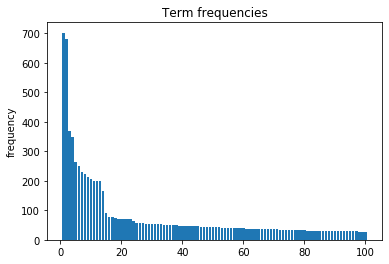

In [12]:
plt.bar(x, y)
plt.title("Term frequencies")
plt.ylabel('frequency')
plt.savefig('../images/term_distribution.png')

How can we explain this figure?
The figure shows a long tail, it can be explain with the fact the a small pottion of frequent item dominate the distribution, and . there is a large number of item with low frequency. This can also be explained as the **80-20** rule.

### III. Time series analysis 

Basically in this  section we will use the field `created_at` of a tweet and answer to this question:
**at what time congolese use twitter the most?**, the answer to this question can be usefull when we want to know when to tweet to reach a maximum audiance.

In [13]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import pickle
from datetime import datetime

In [14]:
def read_tweets_file(path):
    """
    a genrator function which read a json file of tweets and return a iterator of this content file by line
    param:
    path : json file path
    """
    with open(path, 'r') as f :
        for line in f:
            tweet = json.loads(line)
            yield tweet

In [15]:
all_dates = list()
for tweet in read_tweets_file(TWEETS_PATH):
    all_dates.append(tweet.get('created_at'))
idx = pd.DatetimeIndex(all_dates)
ones = np.ones(len(idx))
one_second_series = pd.Series(ones, index=idx)

Downsample the series into 1 minute bins and sum the values of the timestamps falling into a bin.
Basically this helps us to know how many tweet we have in one minute time slot.

In [16]:
per_minute = one_second_series.resample('1Min').apply(sum).fillna(0)

2019-06-03 10:52:52+00:00 2019-06-03 07:23:28+00:00 the date are 


/Users/espoir-mur/Projects/Personnal/twitter-analysis/.venv3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 1224x1008 with 0 Axes>

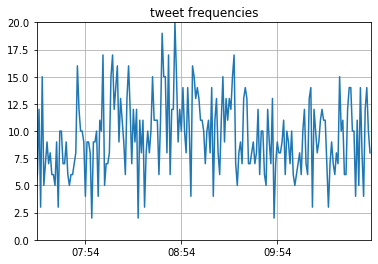

In [17]:
plt.figure(figsize=(17,14))
fig, ax=plt.subplots()
ax.grid(True)
ax.set_title('tweet frequencies')
hours = mdates.MinuteLocator(interval=60)
date_formatter = mdates.DateFormatter('%H:%M')
max_date = idx.max()
min_date = idx.min()
print(max_date, min_date, 'the date are ')
max_freq = per_minute.max()
ax.set_ylim(0,  max_freq)
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(date_formatter)
ax.set_xlim(min_date, max_date)
ax.plot(per_minute.index, per_minute)
plt.savefig('../images/tweet_per_time.png')

We can see from the figure that our tweet were collected from a 30 minutes time intervales (18:00-18:30) and we have the pick time at 18:19 with more that 14 tweets.
Since our time slot was too small we can't find when congolese tweet a lot , but the procedure is set.
If we had more tweet we could estimate with accuracy when the congolese tweet the most and advice some buisness to tweet a lot in that time.

### IV. Create a WordCloud

A wordcloud is a image which looks like a cloud filled with word where the word size is proportional to the frequency of word in a list of words.

We can also say : 
WordCloud is a technique to show which words are the most frequent among the given text.

let install the package 

In [18]:
#!pip install WordCloud

In [19]:
from wordcloud import WordCloud
import matplotlib.colors as colors

we will use our `term_count`counter to generate the world cloud 

In [20]:
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',normalize_plurals=True).generate_from_frequencies(term_counts)

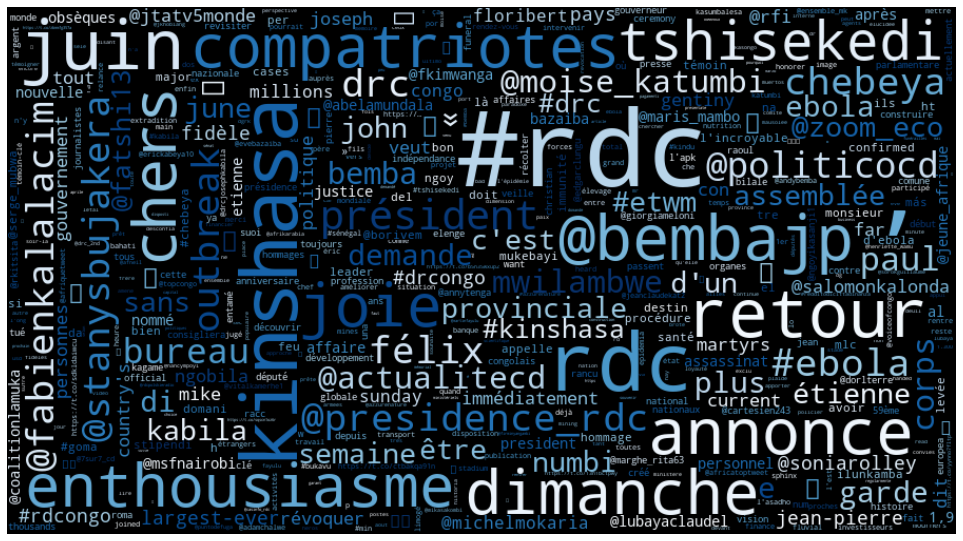

In [21]:
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let us try to create a color map with DRC flag to make the wordcount made with DRC colors to see what will happen.

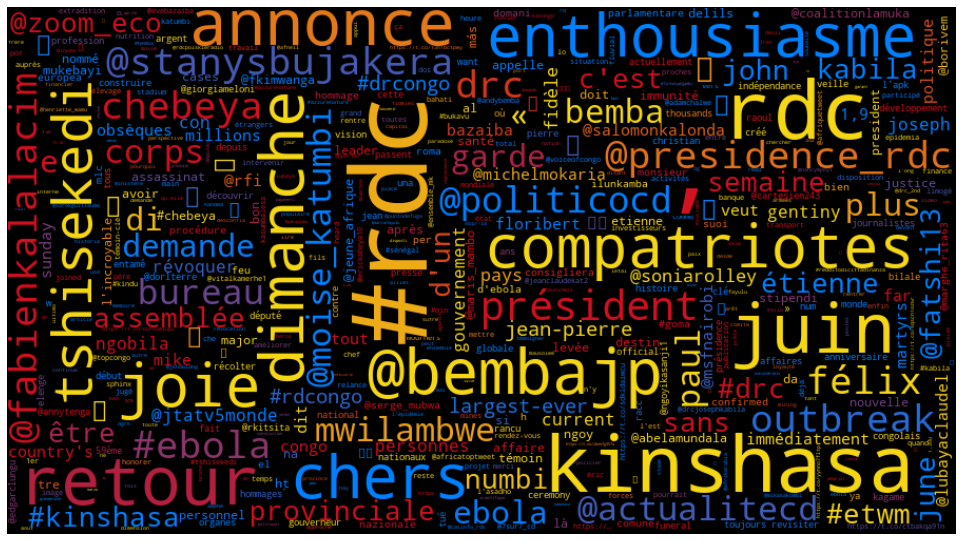

In [23]:
drc_flag_color_map = colors.LinearSegmentedColormap.from_list("", ["#0080FF", 
                                                                   "#0080FF", 
                                                                   "#D00F20",
                                                                   "#D00F20",
                                                                   "#F5D715",
                                                                   "#F5D715"])
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap=drc_flag_color_map,normalize_plurals=True).generate_from_frequencies(term_counts)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### V. Improvement ton twitter preprocessing 

In [24]:
import re
import preprocessor as tweet_preprocessor
import unicodedata
import many_stop_words

As you can see from the wordcount we find meaningless words, ie (c'est, different word counts for a word with hashtag and without hashtag, twitter handles(Idon't know yet if I should remove them or not))
We can use the approachs form [this blogpost](https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf) to refractor our cleaning process.
- the first approach was to use a thrid part libary to clean the tweet. all the cleaning process are done in background with that libray. The library is called : *[tweet-preprocessor](https://pypi.org/project/tweet-preprocessor/)*
- the second approach was to use additional steps after the normal prepocessin we didd, those steps are (emoji removals, replacing consecutives ascii char with spaces)f
- another prepocessing approach to do is to consider the fact that we are dealing with french tweets, we need to do some prepocessing due to the complexity of that language.
- I will also remove the # from the hashtags

In [25]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3',
    ])
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';(', '’:'
    ])
emoticons = emoticons_happy.union(emoticons_sad)
# let append emoticons to words_to remove

words_to_remove = set(words_to_remove).union(emoticons)

In [26]:
len(words_to_remove)

437

let remove also the emojis

In [27]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [28]:
def remove_nonlatin(s): 
    """
    remove non ascii character but keep accent
    """
    s = (ch for ch in s
         if unicodedata.name(ch).startswith(('LATIN', 'DIGIT', 'SPACE')))
    return ''.join(s)

In [29]:
def remove_emoji(text):
    """
    remove the emojis and non ascii char with space from the tweet
    """
    #after tweepy preprocessing the colon symbol left remain after      #removing mentions
    text = re.sub(r':', '', text)
    text = re.sub(r'‚Ä¶', '', text)
    #replace consecutive non-ASCII characters with a space
    text = ' '.join(re.findall(r'[\u0020-\u007F\u00A0-\u00FF\u0100-\u017F\u0180-\u024F]+', text))
    #remove emojis from tweet
    text = emoji_pattern.sub(r'', text)
    return text

Here is the final normalization process:
- remove_using_library
- remove_emoji()
- process_text()
- french_additional_step()

Let do it 

In [30]:
# I decide to keep and hashtags
tweet_preprocessor.set_options(tweet_preprocessor.OPT.URL, 
                               tweet_preprocessor.OPT.EMOJI,
                               tweet_preprocessor.OPT.RESERVED,
                               tweet_preprocessor.OPT.EMOJI, 
                               tweet_preprocessor.OPT.SMILEY,
                               tweet_preprocessor.OPT.NUMBER, )

- let apply french additionnal step by removing the stops word we have , we will use an addional library
add additional french word in list of word to remove

In [31]:
words_to_remove = words_to_remove.union(set(many_stop_words.get_stop_words('FR')))

In [32]:
words_to_remove = words_to_remove.union({'le', 'la', 'de'})

In [33]:
def get_term_count(path):
    """
    preporcess and return terms count from a file of tweets.
    Parm :
    path:  string : the path of the tweet files
    return a dictionary of term and the count of they occurences
    """
    term_counts = Counter()
    for tweet in read_tweets_file(path):
        text = tweet_preprocessor.clean(tweet.get('text'))
        text = text.replace('#', '')
        text = remove_emoji(text)
        tokens = process_text(text=text, tokenizer=tweet_tokenizer, words_to_remove=words_to_remove)
        term_counts.update(tokens)
    return term_counts

In [35]:
for tag, count in get_term_count(TWEETS_PATH).most_common(15):
    print("{}: {}".format(tag, count))

rdc: 1066
kinshasa: 387
juin: 264
retour: 251
annonce: 229
@bembajp: 223
dimanche: 213
chers: 205
compatriotes: 201
joie: 201
enthousiasme: 201
tshisekedi: 180
ebola: 118
drc: 113
chebeya: 92


#### Ploting the wordcount graph again.

In [36]:
drc_flag_color_map = colors.LinearSegmentedColormap.from_list("", ["#0080FF", 
                                                                   "#0080FF", 
                                                                   "#D00F20",
                                                                   "#D00F20",
                                                                   "#F5D715",
                                                                   "#F5D715"])
def generate_word_cloud(term_counts, color_map):
    return WordCloud(width=900,
                     height=500,
                     max_words=500,
                     max_font_size=100,
                     relative_scaling=0.5,
                     colormap=color_map,
                     normalize_plurals=True).generate_from_frequencies(term_counts)
def plot_word_cloud(word_cloud):
    plt.figure(figsize=(17,14))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.savefig('../images/DRC_WORD_COUNT.png')
    plt.axis("off")
    plt.show()

In [39]:
term_counts['ebola'] = term_counts['ebola']+ term_counts['ébola']

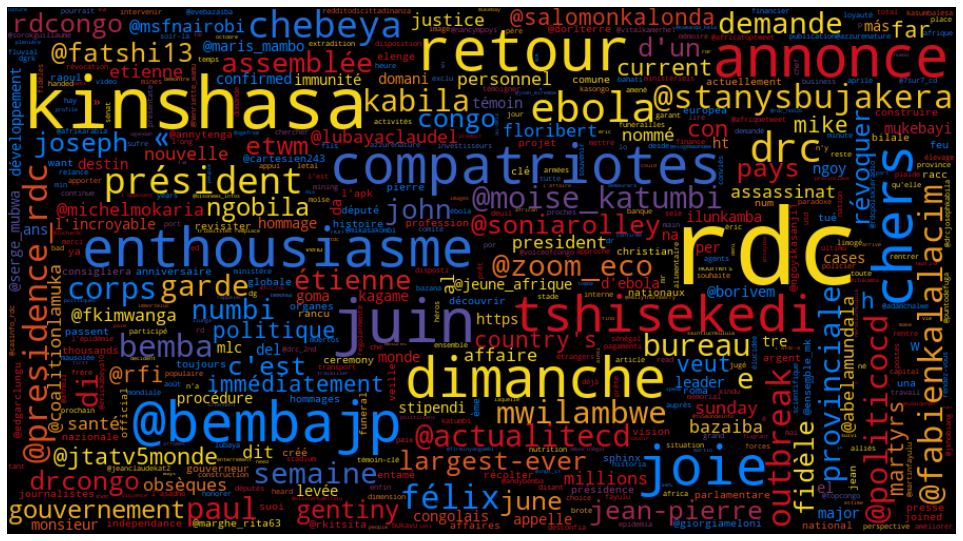

In [40]:
term_counts = get_term_count(TWEETS_PATH)
word_cloud = generate_word_cloud(term_counts, drc_flag_color_map)
plot_word_cloud(word_cloud)

In [41]:
len(term_counts)

4997

#### VI. TWITTER TOPIC MODELING

In [42]:
import spacy
from io import BytesIO
from csv import writer 
from datetime import datetime
french_stematiser = spacy.load('fr')

Basically in this phase we wil train a machine learning model on our tweet to see which topics congoleses are talking about.

we will use co-occurence of word in a tweets , if word always appear together they form a topic.

We will use also the score of a word in a given topic to find the most relevants words in a given topic.

We wiil add another preprossesing step called stemming , stemming :
    
In the next step we stem the words in the list. This is essentially where we knock the end off the words. We do this so that similar words will be recognised as the same word by the algorithm

let try spacy for stematisation.

In [43]:
#!pip install -U spacy

In [44]:
def stematise_token(tokens):
    """
    replace word in token list  with his lemma:
    example : appelais  will become appele, plural will be replaced by their singular version, etc
    """

    doc = french_stematiser(' '.join(tokens))
    return [token.lemma_ for token in doc]

let us remove other words we may find in the tweets such as congo, congolais, rdc, drc since we already knows that those words are related to congo

In [45]:
congo_words = {'congo', 'congolais', 'rdc', 'drc', '-', 'https', 'rdc', 'rdcongo', 'drc', 'drcongo'}
words_to_remove = words_to_remove.union(congo_words)

In [46]:
def prepocess_tweet(tweet):
    """
    Apply all the preprocessing process on a tweet and return the tweet as a text and tweet as list of tokens
    
    """
    text = tweet_preprocessor.clean(tweet.get('text'))
    text = text.replace('#', '')
    text = remove_emoji(text)
    tokens = process_text(text=text, tokenizer=tweet_tokenizer, words_to_remove=words_to_remove)
    tokens = stematise_token(tokens)
    return tokens

In [47]:
 def create_cleaned_df(input_path, output_path):
    """
    take an input file name of tweets , 
    cleaned them write them in a csv file and return a dataframe of cleaned tweets
    """
    output = BytesIO()
    csv_writer = writer(output)

    for tweet in read_tweets_file(input_path):
        csv_writer.writerow(tweet)
    output.seek(0) # we need to get back to the start of the BytesIO
    df = pd.read_csv(output)
    df.to_csv(output_path=output)
    return df

In [48]:
now = datetime.now()
today = now.strftime("%d-%m-%Y-%H-%M")

In [49]:
# the above function is not working but it's the most optimal https://stackoverflow.com/a/48287388/4683950
output_file_name='../data/cleanned_tweets_{}.csv'.format(today)
tweets_df = pd.DataFrame(columns=['cleanned_tweet'])
for tweet in read_tweets_file(TWEETS_PATH):
    tweets_df.loc[tweet.get('id')] = [' '.join(prepocess_tweet(tweet))]
tweets_df.to_csv(output_file_name)

In [103]:
tweets_df = pd.read_csv(output_file_name)

In [104]:
print(output_file_name)

../data/cleanned_tweets_03-06-2019-14-07.csv


In [105]:
#tweets_df = create_cleaned_df('../data/query_drc.jsonl', '../data/cleanned_tweets.csv')

In [106]:
tweets_df.set_index('Unnamed: 0', inplace=True)

In [107]:
tweets_df.dropna(inplace=True)

The next step will be to apply now the algorithm and do topic modeling 

#### VI.b. sklearn phase 

To turn the text into a matrix*, where each row in the matrix encodes which words appeared in each individual tweet. We will also filter the words max_df=0.95 means we discard any words that appear in >90% of tweets. In this dataset I don’t think there are any words that are that common but it is good practice. We will also filter words using min_df=5, so words that appear in less than 25 tweets will be discarded. We discard high appearing words since they are too common to be meaningful in topics. We discard low appearing words because we won’t have a strong enough signal and they will just introduce noise to our model.

In [108]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

In [110]:
vectorizer = CountVectorizer(max_df=0.95, min_df=5, token_pattern='\w+|\$[\d\.]+|\S+')
transfromed_tweets = vectorizer.fit_transform(tweets_df.get('cleanned_tweet'))

<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<ipython-input-110-7314beb6c9b3>:1: DeprecationWarning: invalid escape sequence \w
  vectorizer = CountVectorizer(max_df=0.95, min_df=5, token_pattern='\w+|\$[\d\.]+|\S+')


In [111]:
# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

In [112]:
number_of_topics = 5
topic_modeling_model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0, max_iter=200) 

In [113]:
topic_modeling_model.fit(transfromed_tweets)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=200,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [114]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [115]:
no_top_words = 10
display_topics(topic_modeling_model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,retour,251.2,ebola,98.2,tshisekedi,94.7,le,104.8,de,40.3
1,kinshasa,237.2,outbreak,74.2,de,62.0,kinshasa,64.3,etwm,39.2
2,juin,232.2,@presidence_rdc,69.8,un,52.2,paul,56.2,@fabienkalalacim,37.1
3,annonce,229.2,',67.2,le,51.2,assemblée,50.2,tshisekedi,31.2
4,@bembajp,223.2,s,53.2,être,49.1,demande,49.2,ebola,26.8
5,cher,214.2,@moise_katumbi,43.3,@politicocd,41.9,chebeyer,48.2,le,24.3
6,dimanche,213.2,largest,37.2,juin,32.2,kinshaser,48.1,del,23.2
7,enthousiasme,201.2,ever,37.2,national,32.1,provincial,47.5,goma,23.2
8,compatriote,201.2,country,33.2,nouveau,31.2,bureau,38.7,obsèque,19.2
9,joie,201.2,président,32.3,martyr,31.2,@stanysbujakerer,38.5,président,19.0


### let us visualize the results

In [116]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(topic_modeling_model, transfromed_tweets, vectorizer, mds='tsne')
panel

/Users/espoir-mur/Projects/Personnal/twitter-analysis/.venv3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x          y  topics  cluster       Freq
topic                                                   
0      163.456512  13.816256       1        1  28.733533
2       95.204819  89.011703       2        1  21.060591
3       25.332359 -83.312263       3        1  20.483262
1      126.680328 -76.889908       4        1  17.356903
4       31.089460  14.680798       5        1  12.365711, topic_info=    Category        Freq              Term       Total  loglift  logprob
706  Default  236.000000            retour  236.000000  30.0000  30.0000
156  Default  215.000000           annonce  215.000000  29.0000  29.0000
23   Default  210.000000          @bembajp  210.000000  28.0000  28.0000
222  Default  201.000000              cher  201.000000  27.0000  27.0000
291  Default  200.000000          dimanche  200.000000  26.0000  26.0000
335  Default  189.000000      enthousiasme  189.000000  25.0000  25.0000
459  Default  189.000000              joie  189.000000  24.0000  24.0000
238  Default  189.000000       compatriote  189.000000  23.0000  23.0000
468  Default  248.000000              juin  248.000000  22.0000  22.0000
479  Default  303.000000          kinshasa  303.000000  21.0000  21.0000
321  Default  134.000000             ebola  134.000000  20.0000  20.0000
600  Default   70.000000          outbreak   70.000000  19.0000  19.0000
0    Default   63.000000                 '   63.000000  18.0000  18.0000
94   Default   73.000000   @presidence_rdc   73.000000  17.0000  17.0000
270  Default  119.000000                de  119.000000  16.0000  16.0000
718  Default   50.000000                 s   50.000000  15.0000  15.0000
615  Default   53.000000              paul   53.000000  14.0000  14.0000
342  Default   38.000000              etwm   38.000000  13.0000  13.0000
794  Default   49.000000                un   49.000000  12.0000  12.0000
44   Default   71.000000  @fabienkalalacim   71.000000  11.0000  11.0000
173  Default   48.000000         assemblée   48.000000  10.0000  10.0000
274  Default   47.000000           demande   47.000000   9.0000   9.0000
784  Default  170.000000        tshisekedi  170.000000   8.0000   8.0000
842  Default   73.000000              être   73.000000   7.0000   7.0000
220  Default   53.000000          chebeyer   53.000000   6.0000   6.0000
480  Default   62.000000         kinshaser   62.000000   5.0000   5.0000
486  Default   35.000000           largest   35.000000   4.0000   4.0000
347  Default   35.000000              ever   35.000000   3.0000   3.0000
81   Default   53.000000    @moise_katumbi   53.000000   2.0000   2.0000
668  Default   57.000000        provincial   57.000000   1.0000   1.0000
..       ...         ...               ...         ...      ...      ...
128   Topic5    8.828702            action    9.586700   2.0079  -5.2678
309   Topic5    7.874251           décider    8.626538   1.9990  -5.3822
632   Topic5    7.874251           plenièr    8.626538   1.9990  -5.3822
801   Topic5    7.874221               van    8.626538   1.9990  -5.3822
100   Topic5    7.874180        @rdc_no026    8.626537   1.9990  -5.3822
678   Topic5    7.871732           quitter    8.626487   1.9987  -5.3825
333   Topic5    7.867886          entendre    8.626412   1.9982  -5.3830
52    Topic5    6.913979          @freskot    7.666263   1.9870  -5.5123
535   Topic5    6.913979           millora    7.666263   1.9870  -5.5123
203   Topic5    6.913979              brot    7.666263   1.9870  -5.5123
183   Topic5    6.913979             aviat    7.666263   1.9870  -5.5123
738   Topic5    6.913979          situació    7.666263   1.9870  -5.5123
165   Topic5    6.913979            aquell    7.666263   1.9870  -5.5123
282   Topic5    6.913979           després    7.666263   1.9870  -5.5123
587   Topic5   18.471097           obsèque   26.721757   1.7210  -4.5296
44    Topic5   35.606535  @fabienkalalacim   71.317644   1.3956  -3.8733
402   Topic5   11.645366             grand   16.233725

In [87]:
topic_model_nmf = NMF(n_components=10, random_state=0, alpha=.1, l1_ratio=.5)

In [79]:
topic_model_nmf.fit(transfromed_tweets)

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=200,
    n_components=10, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [80]:
no_top_words = 10
display_topics(topic_model_nmf, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,retour,2.8,le,4.7,ebola,2.9,kinshasa,1.9,di,1.3,de,1.6,paul,1.9,tshisekedi,3.7,kabila,2.1,má,1.7
1,annonce,2.7,de,1.5,outbreak,2.5,provincial,1.8,e,1.2,@fabienkalalacim,1.3,témoin,1.6,président,1.2,affaire,1.6,savoir,0.9
2,kinshasa,2.7,être,0.9,',1.4,assemblée,1.7,tre,1.1,un,1.3,assassinat,1.4,hommage,0.9,joseph,1.3,el,0.9
3,juin,2.7,ebola,0.7,s,1.4,bureau,1.6,stipendi,1.1,@politicocd,1.3,mwilambw,1.4,president,0.8,john,1.1,ya,0.9
4,dimanche,2.6,pays,0.6,ever,1.3,demande,1.5,con,1.1,tshisekedi,1.2,clé,1.4,étienne,0.7,numbi,1.0,epidemia,0.8
5,cher,2.6,tuer,0.6,largest,1.3,ngobila,1.4,al,1.1,féli,1.2,chebeya,1.3,martyr,0.6,chebeyer,1.0,por,0.8
6,enthousiasme,2.6,santé,0.6,june,1.2,gentiny,1.4,da,1.0,fidèle,1.2,floribert,1.2,funeral,0.6,@jeune_afriqu,0.8,muertos,0.8
7,compatriote,2.6,interne,0.6,country,1.1,révoquer,1.4,domani,1.0,corps,1.2,actuellement,0.8,official,0.6,relancer,0.7,desd,0.8
8,joie,2.6,@jtatv5monde,0.6,current,1.1,immédiatement,1.4,consiglierer,1.0,nommer,1.2,kinshaser,0.6,ceremony,0.6,mond,0.7,desconfia,0.8
9,@bembajp,2.5,ong,0.6,far,1.1,raoul,0.8,suoi,1.0,corp,1.2,sénégal,0.6,@edgarclungu,0.5,transport,0.7,brote,0.8


I think I have something to understand tommorrow moring ,
now I can level up on the others topics